In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###Demonstrate using the simulator for a surface simulation, deterministic 
integration.

``Run time``: approximately 35 s (geodist step of local Connect) + ~5 min (workstation circa 2010).

``Memory requirement``: < 1 GB

In [2]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.local_connectivity import LocalConnectivity

from tvb.simulator.lab import *

####Perform the simulation  

In [3]:
LOG.info("Configuring...")

In [4]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()

white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Linear(a=2 ** -9)

In [5]:
#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2 ** -4)

In [6]:
#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=2 ** -1)
mon_savg = monitors.SpatialAverage(period=2 ** -2)
#load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)
#Initialise some Monitors with period in physical time
mon_eeg = monitors.EEG(load_default=True,
                        region_mapping=rm,
                        period=2**-2) 
#Bundle them
what_to_watch = (mon_tavg, mon_savg, mon_eeg)

In [7]:
#Initialise a surface:
#First define the function describing the "local" connectivity.
grey_matter = LocalConnectivity(cutoff=40.0)
grey_matter.equation.parameters['sigma'] = 10.0
grey_matter.equation.parameters['amp'] = 1.0

#then a scaling factor, to adjust the strength of the local connectivity 
local_coupling_strength = numpy.array([-0.0115])

#finally, create a default cortex that includes the custom local connectivity.
default_cortex = Cortex(load_default=True)
default_cortex.local_connectivity = grey_matter
default_cortex.coupling_strength = local_coupling_strength

In [8]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model=oscillator, connectivity=white_matter,
                          integrator=heunint, monitors=what_to_watch,
                          surface=default_cortex)
sim.configure()

Simulator(bound=False, value=None)

In [9]:
LOG.info("Starting simulation...")
#Perform the simulation
tavg_data = []
tavg_time = []
savg_data = []
savg_time = []
eeg_data = []
eeg_time = []

for tavg, savg, eeg in sim(simulation_length=2 ** 6):
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])
    
    if not savg is None:
        savg_time.append(savg[0])
        savg_data.append(savg[1])
    
    if not eeg is None:
        eeg_time.append(eeg[0])
        eeg_data.append(eeg[1])

LOG.info("finished simulation")

####Plot pretty pictures of what we just did

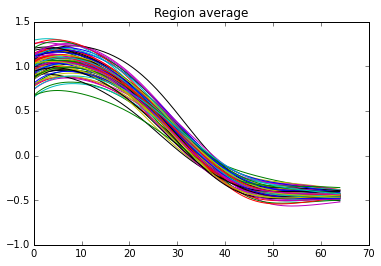

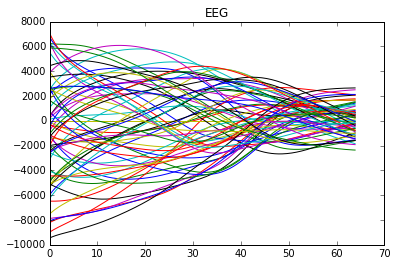

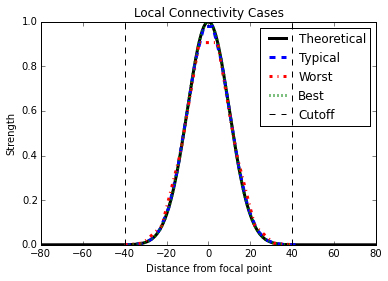

In [11]:
#Make the lists numpy.arrays for easier use.
TAVG = numpy.array(tavg_data)
SAVG = numpy.array(savg_data)
EEG = numpy.array(eeg_data)

#Plot region averaged time series
figure(1)
plot(savg_time, SAVG[:, 0, :, 0])
title("Region average")

#Plot EEG time series
figure(2)
plot(eeg_time, EEG[:, 0, :, 0])
title("EEG")



#Surface movie, requires mayavi.malb
if IMPORTED_MAYAVI:
    st = surface_timeseries(sim.surface, TAVG[:, 0, :, 0])
    
plot_local_connectivity(default_cortex)

#Show them
show()